In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# !pip install tensorflow
# !pip install sklearn
# !pip install skimage
# !pip install colorama

In [3]:
import os
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import cv2
import keras
import math
import numpy as np
from colorama import Fore, Style
from tensorflow.keras import datasets,models
from keras.models import Model
from keras import Sequential
from keras.layers import Convolution2D
import keras.backend as K
from keras.optimizers import Adam
from matplotlib import pyplot as plt
from skimage.metrics import structural_similarity as ssim


In [4]:
#poredimo tj racunamo slicnost izmedju slike A i slike B
# koristeci metriku MSE
# MSE - srednje kvadratna greska izmedju elemenata originalne slike A i
# i izoblicene slike B 
def mean_squared_error(imageA,imageB):
    res = np.power((imageA.astype('float') - imageB.astype('float')),2.)
    res = np.sum(res)
    w = imageA.shape[0]
    h = imageA.shape[1]
    return res/(w*h)
#koristeci psnr
#PSNR - Peak-signal-to-noise-ratio 
def psnr(y_true,y_pred):
    return -10*K.log(K.mean(K.flatten((y_true-y_pred))**2))/np.log(10)

def psnr1(imageA,imageB):
  mse = np.power(imageA.astype('float') - imageB.astype('float'),2)
  mse = np.mean(mse)
  if mse == 0:
    return 100
  return 20*math.log10(255.0/math.sqrt(mse))


def compare_images(imageA,imageB):
    scores = []
    scores.append(psnr(imageA,imageB))
    scores.append(mean_squared_error(imageA,imageB))
    # ssim  se koristi za poredjenje slicnosti izmedju 2 slike
    # ova mera je napravljena kako bi se unapredile tradicionalne metode za ocenu kvaliteta
    # slike kao sto su gore pomenute psnr i mse 
    # multichannel je ukljucen (True) kako bismo mogli raditi sa slikama koje imaju 3 kanala po pikselu(BGR ili RGB format)
    scores.append(ssim(imageA,imageB,multichannel=True))
    return scores

# arg. f-je je  faktor skaliranja slike
def prepare_image(path,factor):
    # prolazimo kroz direktorijum
    # u nasem slucaju taj direktorijum se nalazi na putanji 
    # drive/MyDrive/slike/Set14
    for file in os.listdir(path):
        # povratna vrednost f-je imread je slika koja je ucitana i nalazi se na
        # prosledjenoj putanji path/file 
        img = cv2.imread(path + '/' + file)
        # nakon ucitavanja ispisujemo dimenzije slike
        # ono sto odavde(ako ukljucimo stampanje) mozemo da vidimo je
        # da prvo ide sirina,pa visina,pa broj kanala,
        # nase slike su u boji tako da imamo 3 kanala
        # print('Image: {},dimension: {}'.format(file,img.shape))
    
        #visina,sirina i broj kanala 
        # originalne slike,a zatim i dimenzije modifikovane(sa faktorom umanjenja 
        # factor) slike
        height,width,_ = img.shape
        new_height = int(height/factor)
        new_width = int(width/factor)
        
        # f-ja resize se koristi za promenu velicine slike (sirina,visina)
        # prvo koristimo bilinearnu interpolaciju(ovo je po default-u te nisam morao postaviti parametar interpolation)
        img1 = cv2.resize(img,(new_width,new_height),interpolation = cv2.INTER_LINEAR)  
        img1 = cv2.resize(img1,(width,height),interpolation = cv2.INTER_LINEAR)
         
        # cuvamo modifikovane slike u direktorijumu slike1(rezultat primene bilinearne interpolacije)
        cv2.imwrite('drive/MyDrive/slike1/{}'.format(file),img1)
        
        # drugo koristimo bikubicnu interpolaciju
        img2 = cv2.resize(img,(new_width,new_height),interpolation = cv2.INTER_CUBIC)  
        img2 = cv2.resize(img2,(width,height),interpolation = cv2.INTER_CUBIC)

        cv2.imwrite('drive/MyDrive/slike2/{}'.format(file),img2)

def load_images(inputdir,inputpath):
  imglist = []
  img1list = []
  for i in range(len(inputpath)):
    img = cv2.imread(inputdir + inputpath[i],cv2.IMREAD_COLOR)
    img1 = cv2.imread(inputdir + inputpath[i],cv2.IMREAD_COLOR)

    img1 = cv2.resize(img,(64,64))
    img = cv2.resize(img1,(128,128))
    
    imglist.append(img)
    img1list.append(img1)
  return imglist,img1list

def main():
    prepare_image("drive/MyDrive/slike/Set5",3)  
  

if __name__ == "__main__":
    main()

In [5]:
# IMAGE_SIZE = 128
# CHANNELS = 3

def model(IMAGE_SIZE,CHANNELS):
    model = Sequential()
    model.add(Convolution2D(128,9,activation="relu",input_shape=(IMAGE_SIZE,IMAGE_SIZE,CHANNELS),padding="same"))
    model.add(Convolution2D(64,3,activation="relu",padding="same"))
    model.add(Convolution2D(3,5,activation="relu",padding="same"))
    return model

SRCNN = model(128,3)
# print(SRCNN.summary())

SRCNN1 = model(64,3)
# print(SRCNN1.summary())

In [6]:
image_path = sorted(os.listdir('drive/MyDrive/slike/General-100/General-100'))
image,image1 = load_images('drive/MyDrive/slike/General-100/General-100/',image_path)
image /= np.max(image)
image1 /= np.max(image1)

In [7]:
label = np.zeros((100,128,128,3),np.float32)
label1 = np.zeros((100,64,64,3),np.float32)
for i in range(image.shape[0]):
  temp = cv2.resize(image[i,:,:,:],(64,64))
  label1[i,:,:,:] = temp
  temp = cv2.resize(temp,(128,128))
  label[i,:,:,:]=temp
# print(label.shape)
# print(label1.shape)

In [8]:
initial_lerningrate = 2e-3

def ssim_loss(y_true, y_pred):
  return tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))


SRCNN.compile(loss="mean_squared_error",optimizer=Adam(initial_lerningrate),metrics=[psnr,ssim_loss])
history = SRCNN.fit(label,image,epochs=100,batch_size=32,verbose=1)

Epoch 1/100
4/4 [==============================] - 20s 372ms/step - loss: 1.0913 - psnr: 4.5377 - ssim_loss: 0.2506
Epoch 2/100
4/4 [==============================] - 1s 164ms/step - loss: 0.2884 - psnr: 5.3883 - ssim_loss: 0.0878
Epoch 3/100
4/4 [==============================] - 1s 161ms/step - loss: 0.2206 - psnr: 7.0684 - ssim_loss: 0.2877
Epoch 4/100
4/4 [==============================] - 1s 163ms/step - loss: 0.0655 - psnr: 12.1924 - ssim_loss: 0.5969
Epoch 5/100
4/4 [==============================] - 1s 161ms/step - loss: 0.0385 - psnr: 14.0761 - ssim_loss: 0.6206
Epoch 6/100
4/4 [==============================] - 1s 162ms/step - loss: 0.0642 - psnr: 12.0968 - ssim_loss: 0.5669
Epoch 7/100
4/4 [==============================] - 1s 163ms/step - loss: 0.0375 - psnr: 14.2790 - ssim_loss: 0.6249
Epoch 8/100
4/4 [==============================] - 1s 160ms/step - loss: 0.0368 - psnr: 14.5009 - ssim_loss: 0.6293
Epoch 9/100
4/4 [==============================] - 1s 162ms/step - loss: 0

In [9]:
SRCNN1.compile(loss="mean_squared_error",optimizer=Adam(initial_lerningrate),metrics=[psnr,ssim_loss])
History = SRCNN1.fit(label1,image1,epochs=100,batch_size=32,verbose=1)

Epoch 1/100
4/4 [==============================] - 3s 158ms/step - loss: 0.2978 - psnr: 5.6665 - ssim_loss: 0.1713
Epoch 2/100
4/4 [==============================] - 0s 46ms/step - loss: 0.0934 - psnr: 10.5970 - ssim_loss: 0.3819
Epoch 3/100
4/4 [==============================] - 0s 48ms/step - loss: 0.0479 - psnr: 13.2968 - ssim_loss: 0.4361
Epoch 4/100
4/4 [==============================] - 0s 47ms/step - loss: 0.0421 - psnr: 13.7266 - ssim_loss: 0.4425
Epoch 5/100
4/4 [==============================] - 0s 46ms/step - loss: 0.0413 - psnr: 14.0258 - ssim_loss: 0.4667
Epoch 6/100
4/4 [==============================] - 0s 47ms/step - loss: 0.0333 - psnr: 14.8450 - ssim_loss: 0.4948
Epoch 7/100
4/4 [==============================] - 0s 48ms/step - loss: 0.0283 - psnr: 15.5811 - ssim_loss: 0.5447
Epoch 8/100
4/4 [==============================] - 0s 46ms/step - loss: 0.0242 - psnr: 16.0949 - ssim_loss: 0.5728
Epoch 9/100
4/4 [==============================] - 0s 45ms/step - loss: 0.0213 -

In [10]:
testImage_path = sorted(os.listdir('drive/MyDrive/slike/Set5'))
testImage,testImage1 = load_images('drive/MyDrive/slike/Set5/',testImage_path)

testImage /= np.max(testImage)
testImage1 /= np.max(testImage1)

result  = SRCNN.predict(testImage,batch_size=32)
result1 = SRCNN1.predict(testImage1,batch_size = 32)
# result.shape

Poredjenje originalne slike i interpolirane(bikubicna interpolacija)


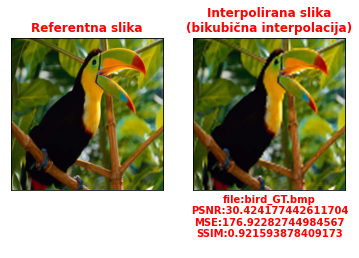

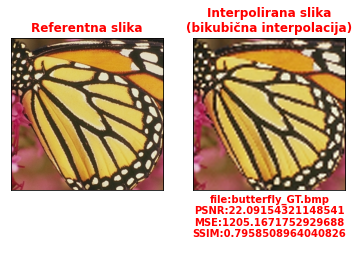

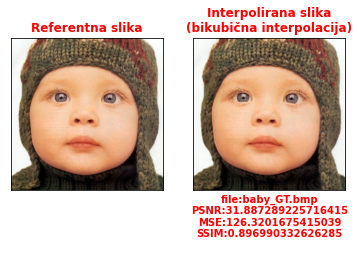

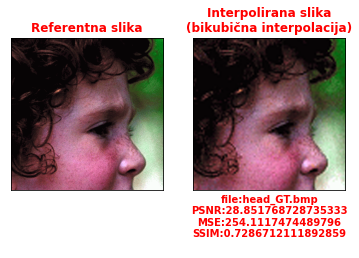

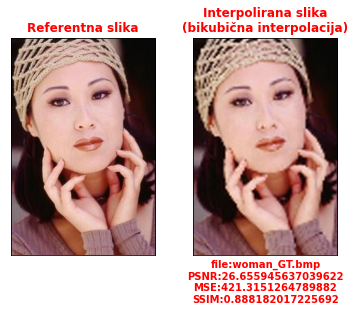

In [11]:
print(Fore.BLUE + 'Poredjenje originalne slike i interpolirane(bikubicna interpolacija)')
for file in os.listdir('drive/MyDrive/slike2/'):
  imageA = cv2.imread('drive/MyDrive/slike2/{}'.format(file))
  imageB = cv2.imread('drive/MyDrive/slike/Set5/{}'.format(file))  
  Psnr = psnr1(imageA,imageB)
  Mse = mean_squared_error(imageA,imageB)
  SSIM = ssim(imageA,imageB,multichannel=True)

  fig = plt.figure()
  ax = fig.add_subplot(1, 2, 1)
  imgplot = plt.imshow(cv2.cvtColor(imageB,cv2.COLOR_BGR2RGB))
  ax.set_title('Referentna slika',fontdict={'fontweight': 'bold','color':'red'})
  ax.set_xticks([])
  ax.set_yticks([])
  
  ax = fig.add_subplot(1, 2, 2)
  imgplot = plt.imshow(cv2.cvtColor(imageA,cv2.COLOR_BGR2RGB))
  # imgplot.set_clim(0.0, 0.7)
  ax.set_title('Interpolirana slika\n(bikubična interpolacija)',fontdict={'fontweight': 'bold','color':'red'})
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_xlabel('file:{}\nPSNR:{}\nMSE:{}\nSSIM:{}\n'.format(file,Psnr,Mse,SSIM),fontdict={'fontweight': 'bold','color':'red'})


Poredjenje originalne slike i interpolirane(bilinearna)


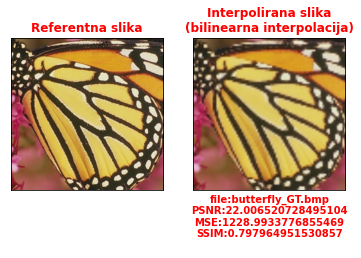

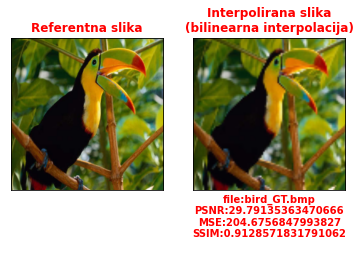

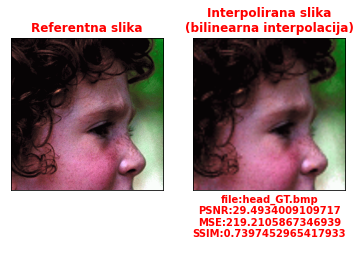

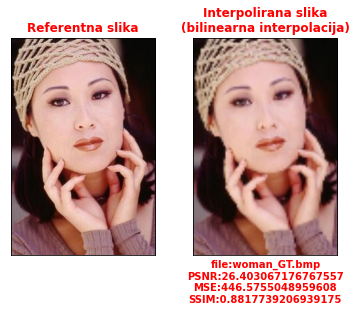

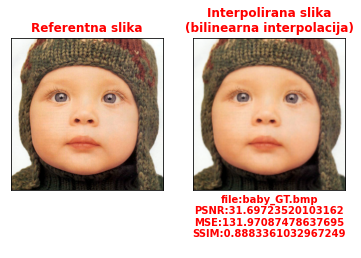

In [12]:
print(Fore.BLUE + 'Poredjenje originalne slike i interpolirane(bilinearna)')
for file in os.listdir('drive/MyDrive/slike1/'):
  imageA = cv2.imread('drive/MyDrive/slike1/{}'.format(file))
  imageB = cv2.imread('drive/MyDrive/slike/Set5/{}'.format(file))
  Psnr = psnr1(imageA,imageB)
  Mse = mean_squared_error(imageA,imageB)
  SSIM = ssim(imageA,imageB,multichannel=True)

  fig = plt.figure()
  ax = fig.add_subplot(1, 2, 1)
  imgplot = plt.imshow(cv2.cvtColor(imageB,cv2.COLOR_BGR2RGB))
  ax.set_title('Referentna slika',fontdict={'fontweight': 'bold','color':'red'})
  ax.set_xticks([])
  ax.set_yticks([])
  
  ax = fig.add_subplot(1, 2, 2)
  imgplot = plt.imshow(cv2.cvtColor(imageA,cv2.COLOR_BGR2RGB))
  imgplot.set_clim(0.0, 0.7)
  ax.set_title('Interpolirana slika\n(bilinearna interpolacija)',fontdict={'fontweight': 'bold','color':'red'})
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_xlabel('file:{}\nPSNR:{}\nMSE:{}\nSSIM:{}\n'.format(file,Psnr,Mse,SSIM),fontdict={'fontweight': 'bold','color':'red'})



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/local/lib/python3.7/dist-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Poredjenje originalne slike i slike dobijene nakon primene SRCNN(9-3-5)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


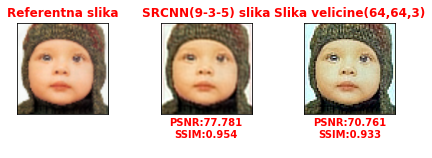

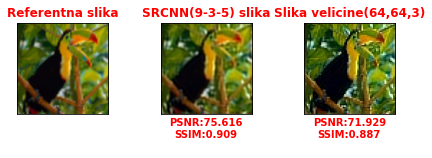

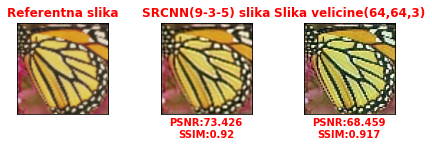

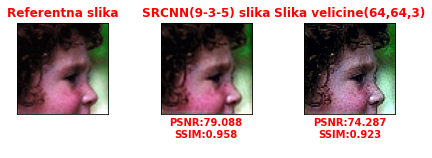

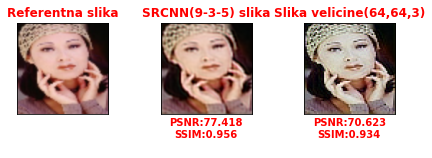

In [14]:
print(Fore.BLUE + 'Poredjenje originalne slike i slike dobijene nakon primene SRCNN(9-3-5)')
i = 0
for i in range(5):
  imageA = result[i] 
  imageB = testImage[i].astype(np.float32)
  
  Psnr = psnr1(imageA,imageB)
  SSIM = ssim(imageA,imageB,multichannel=True)
  

  fig = plt.figure()
  ax = fig.add_subplot(1, 3, 1)
  imgplot = plt.imshow(cv2.cvtColor(imageB,cv2.COLOR_BGR2RGB))
  ax.set_title('Referentna slika',fontdict={'fontweight': 'bold','color':'red'})
  ax.set_xticks([])
  ax.set_yticks([])
  
  ax = fig.add_subplot(1, 3, 2)
  imgplot = plt.imshow(cv2.cvtColor(imageA,cv2.COLOR_BGR2RGB))
  # imgplot.set_clim(0.0, 0.7)
  ax.set_title('SRCNN(9-3-5) slika',fontdict={'fontweight': 'bold','color':'red'})
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_xlabel('PSNR:{}\nSSIM:{}\n'.format(round(Psnr,3),round(SSIM,3),round(Mse,3)),fontdict={'fontweight': 'bold','color':'red'})

  
  imageC = result1[i]
  imageD = testImage1[i]
  i+=1
  
  Psnr1 = psnr1(imageC,imageD)
  SSIM1 = ssim(imageC,imageD,multichannel=True)
  

  ax = fig.add_subplot(1, 3, 3)
  imgplot = plt.imshow(cv2.cvtColor(imageC,cv2.COLOR_BGR2RGB))
  # imgplot.set_clim(0.0, 0.7)
  ax.set_title('Slika velicine(64,64,3)',fontdict={'fontweight': 'bold','color':'red'})
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_xlabel('PSNR:{}\nSSIM:{}\n'.format(round(Psnr1,3),round(SSIM1,3)),fontdict={'fontweight': 'bold','color':'red'})
  plt.tight_layout()




In [15]:
def model1(IMAGE_SIZE,CHANNELS):
    model = Sequential([
                        Convolution2D(64,9,activation="gelu",input_shape=(IMAGE_SIZE,IMAGE_SIZE,CHANNELS),padding="same"),
                        Convolution2D(32,1,activation="gelu",padding="same"),
                        Convolution2D(16,1,activation="gelu",padding="same"),
                        Convolution2D(3,5,activation="gelu",padding="same")
                        ])
    return model

SRCNN = model1(128,3)
# print(SRCNN.summary())

SRCNN1 = model1(64,3)
# print(SRCNN1.summary())

In [16]:
SRCNN.compile(loss="mean_squared_error",optimizer=Adam(initial_lerningrate),metrics=[psnr,ssim_loss])
history1 = SRCNN.fit(label,image,epochs=100,batch_size=32,verbose=1)

Epoch 1/100
4/4 [==============================] - 4s 230ms/step - loss: 0.2091 - psnr: 7.5794 - ssim_loss: 0.2720
Epoch 2/100
4/4 [==============================] - 1s 129ms/step - loss: 0.0589 - psnr: 12.4700 - ssim_loss: 0.6185
Epoch 3/100
4/4 [==============================] - 1s 125ms/step - loss: 0.0278 - psnr: 15.4091 - ssim_loss: 0.6497
Epoch 4/100
4/4 [==============================] - 1s 128ms/step - loss: 0.0294 - psnr: 15.4715 - ssim_loss: 0.6551
Epoch 5/100
4/4 [==============================] - 1s 129ms/step - loss: 0.0229 - psnr: 16.4388 - ssim_loss: 0.6676
Epoch 6/100
4/4 [==============================] - 1s 127ms/step - loss: 0.0214 - psnr: 16.6147 - ssim_loss: 0.6793
Epoch 7/100
4/4 [==============================] - 1s 127ms/step - loss: 0.0189 - psnr: 17.2989 - ssim_loss: 0.6990
Epoch 8/100
4/4 [==============================] - 1s 125ms/step - loss: 0.0166 - psnr: 17.7350 - ssim_loss: 0.7093
Epoch 9/100
4/4 [==============================] - 1s 129ms/step - loss: 

In [17]:
SRCNN1.compile(loss="mean_squared_error",optimizer=Adam(initial_lerningrate),metrics=[psnr,ssim_loss])
History1 = SRCNN1.fit(label1,image1,epochs=100,batch_size=32,verbose=1)

Epoch 1/100
4/4 [==============================] - 2s 89ms/step - loss: 0.2643 - psnr: 6.6037 - ssim_loss: 0.1519
Epoch 2/100
4/4 [==============================] - 0s 39ms/step - loss: 0.0901 - psnr: 10.5432 - ssim_loss: 0.3594
Epoch 3/100
4/4 [==============================] - 0s 35ms/step - loss: 0.0536 - psnr: 12.7453 - ssim_loss: 0.4079
Epoch 4/100
4/4 [==============================] - 0s 38ms/step - loss: 0.0465 - psnr: 13.3498 - ssim_loss: 0.4286
Epoch 5/100
4/4 [==============================] - 0s 40ms/step - loss: 0.0429 - psnr: 13.7516 - ssim_loss: 0.4505
Epoch 6/100
4/4 [==============================] - 0s 36ms/step - loss: 0.0383 - psnr: 14.2511 - ssim_loss: 0.4964
Epoch 7/100
4/4 [==============================] - 0s 35ms/step - loss: 0.0386 - psnr: 14.2467 - ssim_loss: 0.4917
Epoch 8/100
4/4 [==============================] - 0s 34ms/step - loss: 0.0328 - psnr: 14.8946 - ssim_loss: 0.5346
Epoch 9/100
4/4 [==============================] - 0s 36ms/step - loss: 0.0300 - 

In [18]:
result  = SRCNN.predict(testImage,batch_size=32)
result1 = SRCNN1.predict(testImage1,batch_size = 32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/local/lib/python3.7/dist-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Poredjenje originalne slike i slike dobijene nakon primene SRCNN(9-1-1-5)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


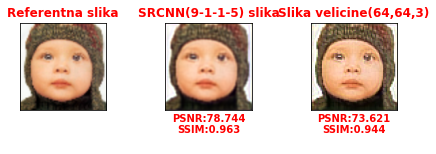

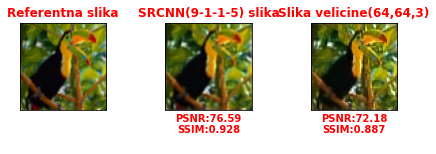

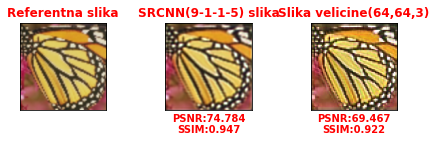

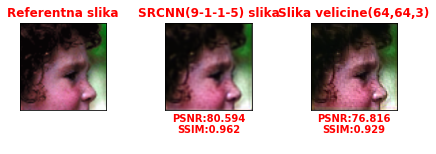

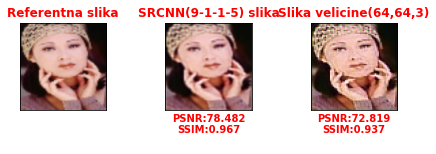

In [20]:
print(Fore.BLUE + 'Poredjenje originalne slike i slike dobijene nakon primene SRCNN(9-1-1-5)')
i = 0
for i in range(5):
  imageA = result[i] 
  imageB = testImage[i].astype(np.float32)
  
  Psnr = psnr1(imageA,imageB)
  SSIM = ssim(imageA,imageB,multichannel=True)
  

  fig = plt.figure()
  ax = fig.add_subplot(1, 3, 1)
  imgplot = plt.imshow(cv2.cvtColor(imageB,cv2.COLOR_BGR2RGB))
  ax.set_title('Referentna slika',fontdict={'fontweight': 'bold','color':'red'})
  ax.set_xticks([])
  ax.set_yticks([])
  
  ax = fig.add_subplot(1, 3, 2)
  imgplot = plt.imshow(cv2.cvtColor(imageA,cv2.COLOR_BGR2RGB))
  # imgplot.set_clim(0.0, 0.7)
  ax.set_title('SRCNN(9-1-1-5) slika',fontdict={'fontweight': 'bold','color':'red'})
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_xlabel('PSNR:{}\nSSIM:{}\n'.format(round(Psnr,3),round(SSIM,3)),fontdict={'fontweight': 'bold','color':'red'})

  
  imageC = result1[i]
  imageD = testImage1[i]
  i+=1
  
  Psnr1 = psnr1(imageC,imageD)
  SSIM1 = ssim(imageC,imageD,multichannel=True)
  

  ax = fig.add_subplot(1, 3, 3)
  imgplot = plt.imshow(cv2.cvtColor(imageC,cv2.COLOR_BGR2RGB))
  # imgplot.set_clim(0.0, 0.7)
  ax.set_title('Slika velicine(64,64,3)',fontdict={'fontweight': 'bold','color':'red'})
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_xlabel('PSNR:{}\nSSIM:{}\n'.format(round(Psnr1,3),round(SSIM1,3)),fontdict={'fontweight': 'bold','color':'red'})
  plt.tight_layout()




In [21]:
def model2(IMAGE_SIZE,CHANNELS):
    model = Sequential()
    model.add(Convolution2D(64,9,activation="elu",input_shape=(IMAGE_SIZE,IMAGE_SIZE,CHANNELS),padding="same"))
    model.add(Convolution2D(32,1,activation="elu",padding="same"))
    model.add(Convolution2D(3,5,activation="elu",padding="same"))
    return model

SRCNN = model2(128,3)
# print(SRCNN.summary())

SRCNN1 = model2(64,3)
# print(SRCNN1.summary())

In [22]:
SRCNN.compile(loss="mean_squared_error",optimizer=Adam(initial_lerningrate),metrics=[psnr,ssim_loss])
history2 = SRCNN.fit(label,image,epochs=100,batch_size=32,verbose=1)

Epoch 1/100
4/4 [==============================] - 2s 126ms/step - loss: 0.3146 - psnr: 5.9960 - ssim_loss: 0.2973
Epoch 2/100
4/4 [==============================] - 0s 78ms/step - loss: 0.1062 - psnr: 10.5509 - ssim_loss: 0.5270
Epoch 3/100
4/4 [==============================] - 0s 79ms/step - loss: 0.0527 - psnr: 13.0508 - ssim_loss: 0.6276
Epoch 4/100
4/4 [==============================] - 0s 83ms/step - loss: 0.0544 - psnr: 13.0350 - ssim_loss: 0.5942
Epoch 5/100
4/4 [==============================] - 0s 79ms/step - loss: 0.0495 - psnr: 13.5608 - ssim_loss: 0.6667
Epoch 6/100
4/4 [==============================] - 0s 82ms/step - loss: 0.0292 - psnr: 15.5083 - ssim_loss: 0.6763
Epoch 7/100
4/4 [==============================] - 0s 83ms/step - loss: 0.0186 - psnr: 17.2638 - ssim_loss: 0.7255
Epoch 8/100
4/4 [==============================] - 0s 78ms/step - loss: 0.0162 - psnr: 18.0448 - ssim_loss: 0.7446
Epoch 9/100
4/4 [==============================] - 0s 82ms/step - loss: 0.0186 -

In [23]:
SRCNN1.compile(loss="mean_squared_error",optimizer=Adam(initial_lerningrate),metrics=[psnr,ssim_loss])
History2 = SRCNN1.fit(label1,image1,epochs=100,batch_size=32,verbose=1)

Epoch 1/100
4/4 [==============================] - 2s 58ms/step - loss: 0.3787 - psnr: 4.5597 - ssim_loss: 0.1521
Epoch 2/100
4/4 [==============================] - 0s 29ms/step - loss: 0.1608 - psnr: 8.2723 - ssim_loss: 0.2548
Epoch 3/100
4/4 [==============================] - 0s 29ms/step - loss: 0.0916 - psnr: 10.5922 - ssim_loss: 0.4408
Epoch 4/100
4/4 [==============================] - 0s 26ms/step - loss: 0.0765 - psnr: 11.5100 - ssim_loss: 0.4552
Epoch 5/100
4/4 [==============================] - 0s 26ms/step - loss: 0.0481 - psnr: 13.3412 - ssim_loss: 0.5265
Epoch 6/100
4/4 [==============================] - 0s 29ms/step - loss: 0.0327 - psnr: 14.9172 - ssim_loss: 0.5779
Epoch 7/100
4/4 [==============================] - 0s 25ms/step - loss: 0.0365 - psnr: 14.5391 - ssim_loss: 0.5864
Epoch 8/100
4/4 [==============================] - 0s 26ms/step - loss: 0.0247 - psnr: 16.0713 - ssim_loss: 0.6388
Epoch 9/100
4/4 [==============================] - 0s 28ms/step - loss: 0.0241 - p

In [24]:
result  = SRCNN.predict(testImage,batch_size=32)
result1 = SRCNN1.predict(testImage1,batch_size = 32)

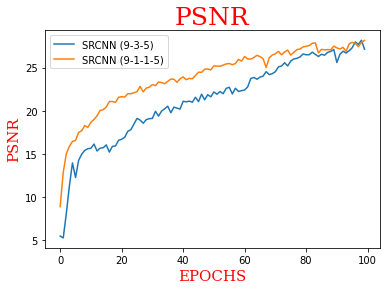

In [25]:
plt.title(label = 'PSNR',fontdict={'family':'serif','color':'red','size':25})
plt.plot(history.epoch,history.history['psnr'])
plt.plot(history1.epoch,history1.history['psnr'])
plt.xlabel('EPOCHS',fontdict={'family':'serif','color':'red','size':15})
plt.ylabel('PSNR',fontdict={'family':'serif','color':'red','size':15})
plt.legend(['SRCNN (9-3-5)','SRCNN (9-1-1-5)'])
plt.show()

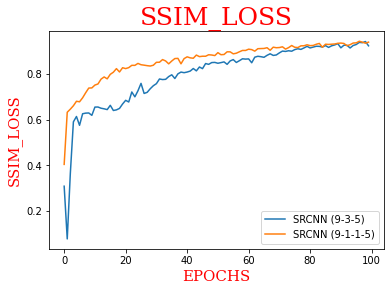

In [26]:
plt.title(label = 'SSIM_LOSS',fontdict={'family':'serif','color':'red','size':25})
plt.plot(history.epoch,history.history['ssim_loss'])
plt.plot(history1.epoch,history1.history['ssim_loss'])
plt.xlabel('EPOCHS',fontdict={'family':'serif','color':'red','size':15})
plt.ylabel('SSIM_LOSS',fontdict={'family':'serif','color':'red','size':15})
plt.legend(['SRCNN (9-3-5)','SRCNN (9-1-1-5)'])
plt.show()

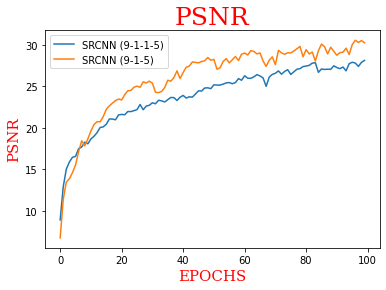

In [27]:
plt.title(label = 'PSNR',fontdict={'family':'serif','color':'red','size':25})
plt.plot(history1.epoch,history1.history['psnr'])
plt.plot(history2.epoch,history2.history['psnr'])
plt.xlabel('EPOCHS',fontdict={'family':'serif','color':'red','size':15})
plt.ylabel('PSNR',fontdict={'family':'serif','color':'red','size':15})

plt.legend(['SRCNN (9-1-1-5)','SRCNN (9-1-5)'])

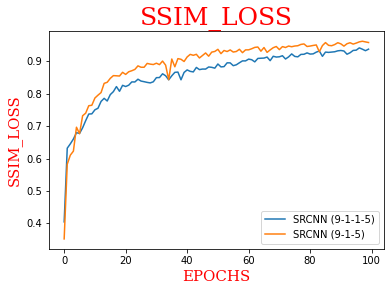

In [28]:
plt.title(label = 'SSIM_LOSS',fontdict={'family':'serif','color':'red','size':25})
plt.plot(history1.epoch,history1.history['ssim_loss'])
plt.plot(history2.epoch,history2.history['ssim_loss'])
plt.xlabel('EPOCHS',fontdict={'family':'serif','color':'red','size':15})
plt.ylabel('SSIM_LOSS',fontdict={'family':'serif','color':'red','size':15})
plt.legend(['SRCNN (9-1-1-5)','SRCNN (9-1-5)'])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/local/lib/python3.7/dist-packages/skimage/metrics/_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Poredjenje originalne slike i slike dobijene nakon primene SRCNN(9-1-5)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


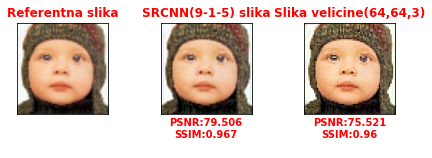

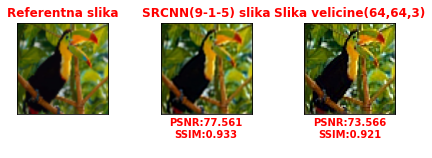

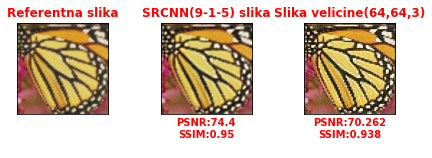

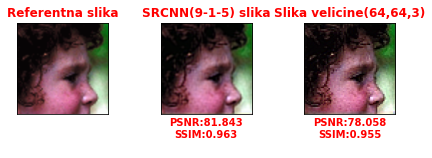

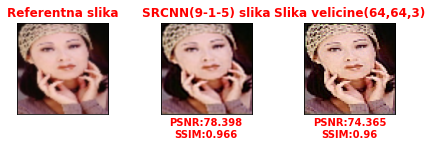

In [30]:
print(Fore.BLUE + 'Poredjenje originalne slike i slike dobijene nakon primene SRCNN(9-1-5)')
i = 0
for i in range(5):
  imageA = result[i] 
  imageB = testImage[i].astype(np.float32)
  
  Psnr = psnr1(imageA,imageB)
  SSIM = ssim(imageA,imageB,multichannel=True)
  

  fig = plt.figure()
  ax = fig.add_subplot(1, 3, 1)
  imgplot = plt.imshow(cv2.cvtColor(imageB,cv2.COLOR_BGR2RGB))
  ax.set_title('Referentna slika',fontdict={'fontweight': 'bold','color':'red'})
  ax.set_xticks([])
  ax.set_yticks([])
  
  ax = fig.add_subplot(1, 3, 2)
  imgplot = plt.imshow(cv2.cvtColor(imageA,cv2.COLOR_BGR2RGB))
  # imgplot.set_clim(0.0, 0.7)
  ax.set_title('SRCNN(9-1-5) slika',fontdict={'fontweight': 'bold','color':'red'})
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_xlabel('PSNR:{}\nSSIM:{}\n'.format(round(Psnr,3),round(SSIM,3)),fontdict={'fontweight': 'bold','color':'red'})

  
  imageC = result1[i]
  imageD = testImage1[i]
  i+=1
  
  Psnr1 = psnr1(imageC,imageD)
  SSIM1 = ssim(imageC,imageD,multichannel=True)
  

  ax = fig.add_subplot(1, 3, 3)
  imgplot = plt.imshow(cv2.cvtColor(imageC,cv2.COLOR_BGR2RGB))
  # imgplot.set_clim(0.0, 0.7)
  ax.set_title('Slika velicine(64,64,3)',fontdict={'fontweight': 'bold','color':'red'})
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_xlabel('PSNR:{}\nSSIM:{}\n'.format(round(Psnr1,3),round(SSIM1,3)),fontdict={'fontweight': 'bold','color':'red'})
  plt.tight_layout()


